In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import random 

from sklearn.model_selection import cross_validate
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC

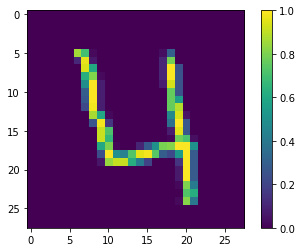

In [2]:
mnist = pd.read_csv('train.csv')

y = np.array(mnist['label'])

X = np.array(mnist.iloc[:,1:])
#on normalise entre 0 et 1
X = (X-np.min(X))/(np.max(X)-np.min(X))

#transformation en sparse matrix ??
sX = sparse.csr_matrix(X)

plt.imshow(X[3].reshape(28,28))
plt.colorbar()

In [3]:
class MyPerceptron:
    def __init__(self):
        self.w = None
        self.b = None
    
    def fit(self, X, y, nbiter=10000, b=1, alpha=1):
        self.b = b
        #self.w = np.zeros(X.shape[1])
        self.w = np.random.rand(X.shape[1])
        for i in range(nbiter):
            index = random.randrange(len(y))
            #if y[index] * (np.dot(self.w, X[index]) + self.b) < 0:
            if max(0, alpha - y[index]*(np.dot(self.w, X[index])+self.b)) > 0:
                self.w = self.w + (y[index] * X[index])
    
    def predict(self, x):
        return np.sign(np.dot(x, self.w))

In [4]:
def predict_Multiclass(clfs, X, methode):
    n = len(clfs)
    if (methode=='ova'):
        res = []
        for i in range(n):
            res.append(clfs[i].predict(X))
        return np.argmax(np.array(res).T,axis=1)
    
    if (methode=='ovo'):
        res = []
        for x in X:
            tmp = np.zeros(n)
            for i in range(n):
                for j in range(i+1, n):
                    if clfs[i][j].predict(x)>=0:
                        tmp[i] += 1
            res.append(np.argmax(tmp))
        return res

In [73]:
#TEST de mon perceptron en one vs all pour chaque chiffre
clfs=[]
for i in range(10):
    yi = np.where(y == i, 1, -1)
    clf = MyPerceptron()
    clf.fit(X, yi, alpha=1)
    clfs.append(clf)
print('precision:', np.mean(predict_Multiclass(clfs, X, methode='ova')==y))

precision: 0.8724761904761905


In [80]:
#perceptron de sklearn
clf = Perceptron()
clf.fit(X, y)

score = cross_validate(clf, X, y, cv=5, scoring='accuracy')
print(score)
print(np.mean(score['test_score']))

{'fit_time': array([5.00427604, 5.10838413, 4.70403719, 4.44131184, 4.76759219]), 'score_time': array([0.01100993, 0.01101017, 0.01100969, 0.01050878, 0.01100922]), 'test_score': array([0.83369048, 0.88309524, 0.88416667, 0.8652381 , 0.89404762])}
0.8720476190476191


In [82]:
clfRidge = Perceptron(penalty='l2')
clfRidge.fit(X, y)

score = cross_validate(clfRidge, X, y, cv=5, scoring='accuracy')
print(score)
print(np.mean(score['test_score']))

{'fit_time': array([3.13869381, 2.72333717, 3.15721011, 3.22676969, 3.33986616]), 'score_time': array([0.01101017, 0.01050949, 0.01050901, 0.01050973, 0.01050901]), 'test_score': array([0.86059524, 0.83285714, 0.82547619, 0.84964286, 0.84285714])}
0.8422857142857142


In [84]:
clfLasso = Perceptron(penalty='l1')
clfLasso.fit(X, y)

score = cross_validate(clfLasso, X, y, cv=5, scoring='accuracy')
print(score)
print(np.mean(score['test_score']))

{'fit_time': array([13.6832428 , 11.68052435, 13.54362369, 12.9130826 , 13.01216745]), 'score_time': array([0.01100969, 0.01050973, 0.01100922, 0.01100922, 0.01050973]), 'test_score': array([0.88678571, 0.88095238, 0.83464286, 0.87154762, 0.85761905])}
0.8663095238095238


# SVM et Grid Search

In [106]:
X.shape

(42000, 784)

In [116]:
Xshort = X[:int(len(y)/10)]
yshort = y[:int(len(y)/10)]

In [87]:
svm = SVC(kernel='linear')

In [88]:
svm.fit(X, y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [90]:
print('precision:', np.mean(svm.predict(X)==y))

precision: 0.9772380952380952


In [101]:
kernel = ['linear', 'poly', 'sigmoid']
gamma = [0.01, 0.001, 0.0001]
C = [1, 10, 100, 1000]

In [ ]:
scores = []
for k in kernel:
    print(k)
    scores.append([])
    for g in gamma:
        scores[-1].append([])
        for c in C:
            svm = SVC(kernel=k, gamma=g, C=c)
            svm.fit(Xshort, yshort)
            score = cross_validate(svm, Xshort, yshort, cv=3, scoring='accuracy')['test_score']
            scores[-1][-1].append([np.mean(score), np.std(score)])

In [ ]:
#peu importe le gamma et le c en linear, on a le meme score : [0.9040476190476191, 0.005841830545897785]
#meilleur score : 'poly / 0.01 / 100 & 1000' [0.9366666666666668, 0.0029354352395090295]
#pire score atteint pour tous les C en poly, 0.0001. [0.10952380952380954, 0.0003367175148507344]
scores[1][0][2]

In [95]:
svm = SVC(kernel='linear')
svm.fit(Xshort, yshort)
score = cross_validate(svm, Xshort, yshort, cv=5, scoring='accuracy')['test_score']
np.mean(score)

0.9097619047619048

In [117]:
svm = SVC(kernel='poly', gamma=0.01, C=100)
svm.fit(Xshort, yshort)
score = cross_validate(svm, Xshort, yshort, cv=5, scoring='accuracy')['test_score']
np.mean(score)

0.9366666666666668

In [118]:
svm = SVC(kernel='poly', gamma=0.01, C=100)
svm.fit(X, y)

SVC(C=100, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [119]:
#soumission KAGGLE
Xtest = np.array(pd.read_csv('test.csv'))
#sXtest = sparse.csr_matrix(Xtest)

res = svm.predict(Xtest)

f = open('submission_svm_poly_001_100.csv', 'w')
f.write("ImageId,Label\n")
for i in range(len(res)):
    f.write(str(i+1)+","+str(res[i])+"\n")
f.close()

# Vizualisation 2D

In [5]:
from arftools import *
from tme4_etu import *

In [6]:
def kernelTrick(data):
    res = np.hstack((
        data,
        (data[:,0] * data[:,0]).reshape(-1,1),
        (data[:,1] * data[:,1]).reshape(-1,1),
        (data[:,0] * data[:,1]).reshape(-1,1),
        np.ones((len(data),1))
    ))
    return res

In [20]:
trainx,trainy =  gen_arti(nbex=1000,data_type=1, epsilon=0, sigma=0.2)
testx,testy =  gen_arti(nbex=1000,data_type=1, epsilon=0, sigma=0.2)

#ajout du biais w0 et la colonne de 1 dans datax
trainx2 = np.hstack((trainx, np.ones((len(trainx),1))))
testx2 = np.hstack((testx, np.ones((len(testx),1))))

trainx_kernel = kernelTrick(trainx)
testx_kernel = kernelTrick(testx)

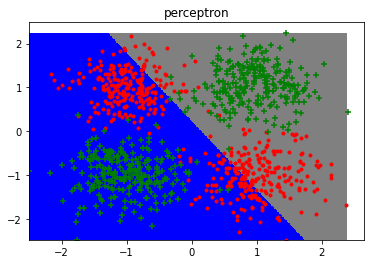

In [21]:
clf1 = MyPerceptron()
clf1.fit(trainx2,trainy)

plt.figure()
plot_frontiere(trainx2, clf1.predict, 200)
plt.title('perceptron')
plot_data(trainx,trainy)

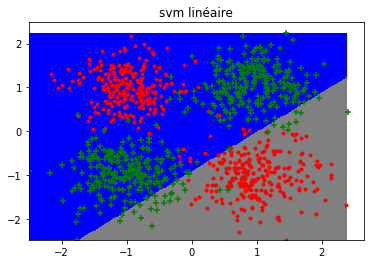

In [22]:
clf2 = SVC(kernel='linear')
clf2.fit(trainx2,trainy)

plt.figure()
plot_frontiere(trainx2, clf2.predict, 200)
plt.title('svm linéaire')
plot_data(trainx,trainy)

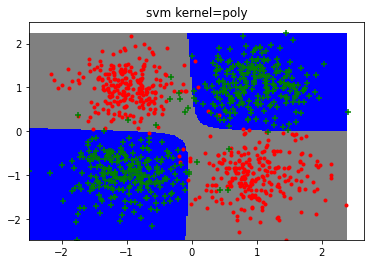

In [23]:
clf3 = SVC(kernel = 'poly', C=100, gamma=0.01)
clf3.fit(trainx2,trainy)

plt.figure()
plot_frontiere(trainx2, clf3.predict, 200)
plt.title('svm kernel=poly')
plot_data(trainx,trainy)

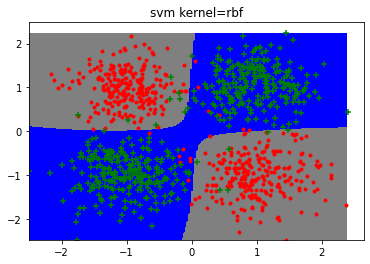

In [25]:
clf4 = SVC(kernel = 'rbf')
clf4.fit(trainx2,trainy)

plt.figure()
plot_frontiere(trainx2, clf4.predict, 200)
plt.title('svm kernel=rbf')
plot_data(trainx,trainy)